# PyTorch workflow

The implementation and learning of PyTorch workflow

Follow freeCodeCamp.org, what will be covered: 
1. : "data (prepare data and load),
2. : "build a model",
3. : "train the model using prepared data, 
4. : "saving model checkpoint and load it up", 
5. : "combine what we learn together"

In [10]:
import torch
print(torch.cuda.is_available())

from torch import nn 
import matplotlib.pyplot as plt 

print(torch.__version__)

True
2.5.1+cu124


##  1. Data (prepare data and loading data)

This will consist of: 
* Excel spreadsheet
* Image
* Video - Images
* Audio
* Text for LLM

Machine can not read our data, it can only read 0 and 1 - numerical version of data, so we have to: 
1. Convert data into numerical version 
2. Build a model to learn some what of a patterns from those datas

Like any old school lession the first form of "learnable" thing come in with linear regression with 
`Y = aX + b`, we'll use this formualla to make a straight line base on our data. 

In [5]:
# first create some data
import torch
weight = 0.3
bias = 0.7
X = torch.arange(start = 0, end = 1, step = 0.02).unsqueeze(dim = 1) # add another dimension 
Y = weight * X + bias

print(X[:10])
print(Y[:10])

print(len(X), len(Y))

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])
tensor([[0.7000],
        [0.7060],
        [0.7120],
        [0.7180],
        [0.7240],
        [0.7300],
        [0.7360],
        [0.7420],
        [0.7480],
        [0.7540]])
50 50


### Splitting the data into train and test set (validate if we can). 
* Training set -> the model learns from this data - ~60-80%
* Validation set -> used to tune the model
* Test -> the model will get evaluated on this dataset to see what it learn and how well it perform 

In [6]:
# create train/test split 

train_split = int(0.8 * len(X))
print(train_split)

X_train, Y_train = X[:train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]

print(len(X_train))

40
40


In [7]:
def plot_predictions(train_data = X_train, 
					 train_labels = Y_train, 
					 test_data = X_test, 
					 test_labels = Y_test, 
					 predictions=None):
	plt.figure(figsize=(10,7))

	# Plot the training data 
	plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

	# Plot test data 
	plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

	if predictions is not None: 
		plt.scatter(test_data, predictions, c="r", s=4, label="Prediction")

	plt.legend(prop={"size": 14})

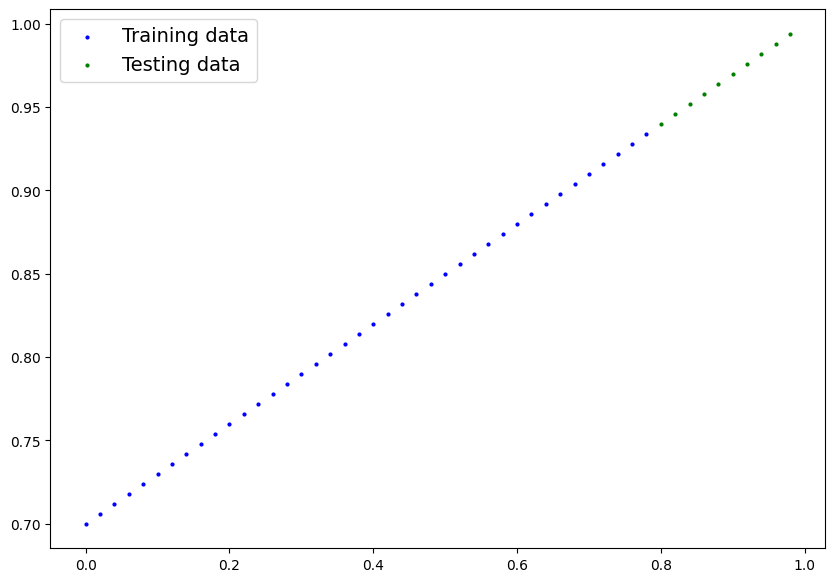

In [5]:
plot_predictions()

## 2. Building our very first model using PyTorch

Some note is that sine I've already familiar with gradient descend, it should not be noted here. The model basically: 
* Start with random values of weights and bias 
* Take in the training data and see how wrong it is -> adjust the random value 
* The adjustment happend thanks for using gradient descent and back propagation

### To build a model in PyTorch, there some essential thing to remember: 
* torch.nn - the foundation to build the computational graphs (or so can say a model)
* torch.nn.Paramerter - P is captialize - don't miss it :v, this one decide what params should model try (forward) and learn. As in the freecodecamp.org code guy said: "often a PyTorch layer from torch.nn will set these for us"
* torch.nn.Module - The base class for all neural network modules, if we subclass (inherit) like below you muse overwrite the forward method
* torch.optim - optim = optimizer, they will handle the gradient descent
* foward() - every model use this method to try (compute) from the input and produce the output

In [76]:
import torch
from torch import nn
# Create a linear regression model with PyTorch
class LinearRegression(nn.Module): # <- almost everything in pytorch inherit from nn.module
    # In PyTorch a module can contain another module, this feature allow us to build compliated model. 
    def __init__(self):
        # Use the default constructor from the nn.module base class
        super().__init__()
        self.weight = nn.Parameter(torch.rand(1, 
                                              requires_grad = True, # <- allow differentiation for gradient descent
                                              dtype = torch.float))
        
        self.bias = nn.Parameter(torch.rand(1, 
                                            requires_grad= True, 
                                            dtype= torch.float))
        
    # define a "forward" method - which is a mothod to put the input in and compute through the model
    def forward(self, x: torch.tensor) -> torch.tensor:
        # as the formualla for a linear function is ax + b = y
        return self.weight * x + self.bias

### Checking our PyTorch model 
Now we've created a model, let's see what's inside the model by using `.parameters()`.

In [77]:
# Create a random seed 
torch.manual_seed(42)

# create an instance for linearregression model 
model = LinearRegression()

# check out the model parameters
list(model.parameters())


[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

### Making prediction using `torch.inference_mode()`

* so why the inference mode ? 
* You can try run this without infernce_mode() context, but it will add the backward gradient function
* This help pytorch tracking data when you run training, but for inference, you won't need to do it 
* basically, it help your code faster

In [78]:
# Listed named parameters 
model.state_dict()

with torch.inference_mode():
    y_preds = model(X_test)

# no grad work too, but inference mode is prefer since it optimze better for the inerence process
with torch.no_grad():
    y_preds = model(X_test)

y_preds


tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])

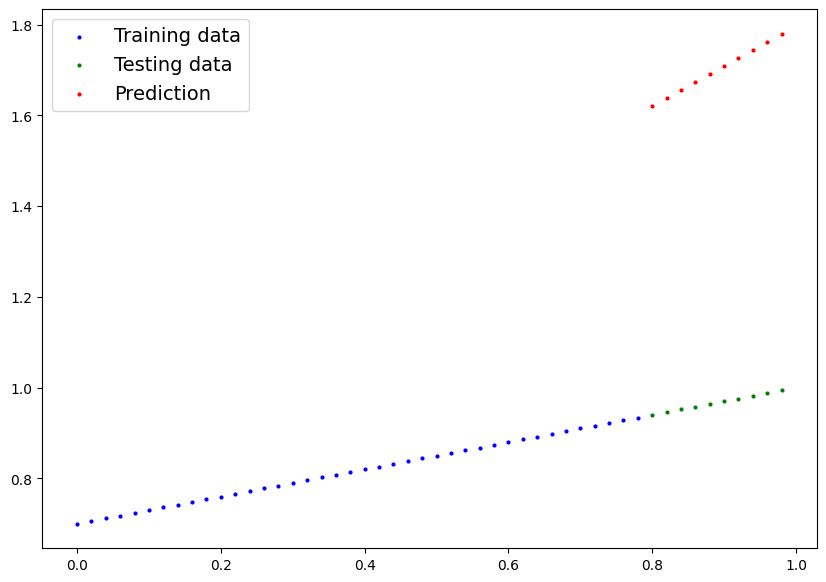

In [79]:
plot_predictions(predictions=y_preds)

## 3. Train model 
Simple way to explain what the training process is to: \\
run the model -> see how wrong it is -> adjust the parameters -> repeat again ... 

* To determine how wrong or how far is the prediction compare to the actual result, we use lost function 
* **Lost function:** is a function to determine how far our prediction compare to the ground truth. 
* It some time refer as **cost function** or **criterion**, but from my exp, the **cost funciton** term is used for lost functino **over a batch or a whole dataset** 
* **Optimizer** Takes into account how lost we are and adjust the parameters

For PyTorch, we mainly focusing on: 
* A loop for training 
* A loop for testing

### Setting up lost function and optimzation method for optimizer

In [80]:
# Setup a loss function 
loss_fn = nn.L1Loss()

# Setup an optimizer 
optimizer = torch.optim.SGD(params= model.parameters(),
                            lr= 0.01) # learning rate, higher the learning rate, the more aggressive the model adjust it weight

### Building a training loop (and testing loop) in PyTorch
The step by step when we training basically are:

0. Loop through the data
1. Consume it and forward it to get the predction result 
2. Calculate loss - how much the result is far a way from the ground truth 
3. Optimizer zero grad 
4. Loss backward - back propagation using chain rule to calcualte the gradien to adjust the loss backward in the NN 
5. Optimizer step - use the optimizer to adjust the model's parameters - improve the loss on the next run. (**gradient descent**)


In [81]:
model.parameters()

epochs = 180

epoch_count = []
loss_value = []
test_loss_value = []

# step 0 
for epoch in range(epochs):
    # Set the model to training mode 
    model.train() # Set all the params in the model require gradient to requires_gradient = True

    # step 1 forward the data
    y_preds = model(X_train)

    # step 2 calculate the lost
    loss = loss_fn(y_preds, Y_train)
    # step 3 optimize zero grad 
    optimizer.zero_grad()

    # step 4 back propogation
    loss.backward()

    # step 5 the optimizer (perform gradient descent)
    optimizer.step()

    ### Testing 
    # We basically turn off all the training relevant tracking stuff to 
    # run inference and check how well have the model perform 
    model.eval() # turns off gradient tracking
    with torch.inference_mode():
        # do the forward part 
        test_pred = model(X_test)

        # calculate the lost
        test_lost = loss_fn(test_pred, Y_test)
        test_loss_value.append(test_lost)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_lost}")
        print(model.state_dict())
    
    epoch_count.append(epoch)
    loss_value.append(loss)
    # Print out model state dict 


Epoch: 0 | Loss: 0.4420889914035797 | Test loss: 0.7197526097297668
OrderedDict([('weight', tensor([0.8784])), ('bias', tensor([0.9050]))])
Epoch: 10 | Loss: 0.3268791139125824 | Test loss: 0.5850428342819214
OrderedDict([('weight', tensor([0.8394])), ('bias', tensor([0.8050]))])
Epoch: 20 | Loss: 0.2116692066192627 | Test loss: 0.4503329396247864
OrderedDict([('weight', tensor([0.8004])), ('bias', tensor([0.7050]))])
Epoch: 30 | Loss: 0.12756893038749695 | Test loss: 0.3369595408439636
OrderedDict([('weight', tensor([0.7623])), ('bias', tensor([0.6255]))])
Epoch: 40 | Loss: 0.09492673724889755 | Test loss: 0.26464295387268066
OrderedDict([('weight', tensor([0.7294])), ('bias', tensor([0.5825]))])
Epoch: 50 | Loss: 0.08234723657369614 | Test loss: 0.22002406418323517
OrderedDict([('weight', tensor([0.7023])), ('bias', tensor([0.5620]))])
Epoch: 60 | Loss: 0.07639807462692261 | Test loss: 0.19289220869541168
OrderedDict([('weight', tensor([0.6796])), ('bias', tensor([0.5550]))])
Epoch: 

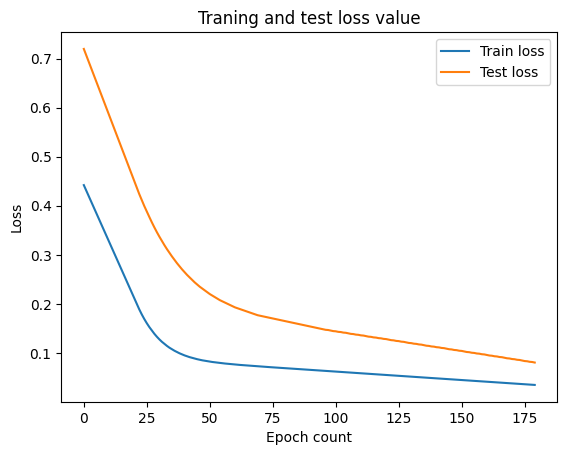

In [86]:
# plot up the loss to track for model
import numpy as np  
plt.plot(epoch_count, np.array([loss.detach().numpy() for loss in loss_value]), label="Train loss")
plt.plot(epoch_count, np.array([loss.detach().numpy() for loss in test_loss_value]), label="Test loss")
plt.title("Traning and test loss value")
plt.ylabel("Loss")
plt.xlabel("Epoch count")
plt.legend()
plt.show()

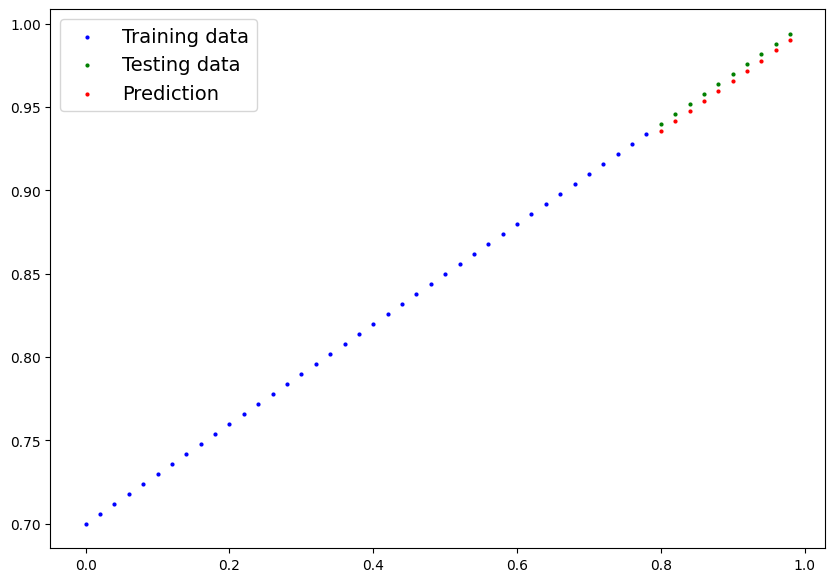

In [70]:
with torch.inference_mode(): 
    new_predicts = model(X_test)
    plot_predictions(predictions=new_predicts)
    

### Important notes here:
* What loss function and optimizer should we shoose ? 
* For a regression problem a loss function like `nn.L1Loss()` and optmizer like `torch.optim.SGD()` is used.\
But for classification the output should be squeeze into the range of 0 and 1, loss functino would be `nn.BCEloss()`, binary cross entropy loss. 